# Part 3. Enhancement
The RNN model used in Part 2 is a basic model to perform the task of sentiment classification. In
this section, you will design strategies to improve upon the previous model you have built. You are
required to implement the following adjustments:

5. Further improve your model. You are free to use any strategy other than the above mentioned solutions. Changing hyper-parameters or stacking more layers is not counted towards
a meaningful improvement.


## Question 5f

In this open solution, we detail the our approach where we explore if the inclusion
of self attention in the RNN baseline model can serve to improve the model to 
perform well for this dataset.


### Approach

We will use the original RNN model defined in Part 2 and add a self attention layer
to the model. The self attention layer will be added after the RNN layer and before the
final dense layer. The self attention layer will help the model to focus on the most
important words in the sentence and hence improve the performance of the model.

This is in contrast to just applying a simple max pooling where we only simply obtain
the max value of the hidden states of the RNN layer.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from common_utils import EmbeddingMatrix
from common_utils import train_model, plot_loss_accuracy, test_loop, set_seed
from common_utils import HIDDEN_SIZE, EMBEDDING_DIM, LEARNING_RATE
# set seed 
set_seed()

In [2]:
from common_utils import CustomDatasetPreparer, BATCH_SIZE


dataset_preparer = CustomDatasetPreparer(
    dataset_name="rotten_tomatoes",
    batch_size=BATCH_SIZE
)

train_loader, val_loader, test_loader = dataset_preparer.get_dataloaders()

In [3]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x,_,lenghts, sample_y = next(dataiter)

# print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)
print()
print('Sample label size: ', lenghts.size()) # batch_size
print('Sample label: \n', lenghts)

Sample input: 
 tensor([[ 7669,    21,   232,  ..., 16163, 16163, 16163],
        [ 7669,    21,   232,  ..., 16163, 16163, 16163],
        [14397,  7656, 14339,  ..., 16163, 16163, 16163],
        ...,
        [ 7669, 15634,  9410,  ..., 16163, 16163, 16163],
        [12070,    24,  6442,  ..., 16163, 16163, 16163],
        [ 7669, 12475,  8317,  ..., 16163, 16163, 16163]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 1])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([24, 19, 23, 22, 17, 31, 18, 16, 23, 25, 25, 37, 33,  9,  6, 27, 43, 23,
        11, 26, 23, 23, 14, 35, 38, 28, 19,  5, 28, 28, 21, 32, 22, 10, 11, 10,
         7, 14, 22, 15, 21, 13, 23,  4, 30, 32,  9, 31, 17, 23])


# Part 3 - Open topic

## RNN with attention

We first explore if the use of attention in RNN can improve the performance of the model. Our
basis is that the attention mechanism can help the model to focus on the most relevant words in the
input sequence.

In [118]:
class RNNWithAttention(nn.Module):

    def __init__(
        self,
        hidden_dim: int,
        embedding_dim: int,
        word_embeddings: torch.Tensor,
        pad_idx,
        num_layers=1,
        output_size=1,
        dropout_rate=0
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=False, padding_idx=pad_idx)
        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, num_layers, batch_first=True
        )  # this is the num rows of the input matrix
        self.attention = nn.Linear(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, text_lengths):
        embedded = self.embedding(x)
        
        if self.dropout_rate > 0:
            embedded = self.dropout(self.embedding(x)).float()
        else:
            embedded = self.embedding(x).float()

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted = False)
        packed_output, _ = self.rnn(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        if self.dropout_rate > 0:
            output = self.dropout(output)
        
        # Calculate attention scores
        attention_weights = torch.softmax(self.attention(output), dim=1)
        # Apply attention weights to RNN outputs
        context_vector = torch.sum(attention_weights * output, dim=1)
        out = self.fc(context_vector)
        sig_out = self.sigmoid(out)
        # sig_out = sig_out.squeeze(1)
        return sig_out

from common_utils import HIDDEN_SIZE, EMBEDDING_DIM, LEARNING_RATE
# initialize word embeddings
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()
word_embeddings.add_unk_token()

print("The index of <PAD> is: ", word_embeddings.pad_idx)


rnn_attention = RNNWithAttention(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    dropout_rate=0.6,
    pad_idx=word_embeddings.pad_idx,
    num_layers=1,
)

The index of <PAD> is:  16163


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
es_patience = 15

model = rnn_attention
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.05)

model = model.to(device)
loss_fn = loss_fn.to(device)

In [120]:
train_loss_, train_acc_, val_loss_, val_acc_ = train_model(train_loader, val_loader, model, loss_fn, optimizer, scheduler, epochs, es_patience)

  1%|          | 1/100 [00:02<04:11,  2.54s/it]

epoch 1, train_loss 0.671502 train_acc 0.592849, val_loss 0.687796, val_acc 0.569418


 11%|█         | 11/100 [00:26<03:35,  2.42s/it]

epoch 11, train_loss 0.353283 train_acc 0.848183, val_loss 0.526597, val_acc 0.751407


 21%|██        | 21/100 [00:50<03:04,  2.33s/it]

epoch 21, train_loss 0.358341 train_acc 0.841735, val_loss 0.520673, val_acc 0.749531


 31%|███       | 31/100 [01:13<02:40,  2.33s/it]

epoch 31, train_loss 0.356464 train_acc 0.847245, val_loss 0.536626, val_acc 0.751407


 35%|███▌      | 35/100 [01:25<02:39,  2.45s/it]

early stopping after 36 epochs
best val loss: 0.520673161203211
best accuracy on val set: 0.7523452157598499


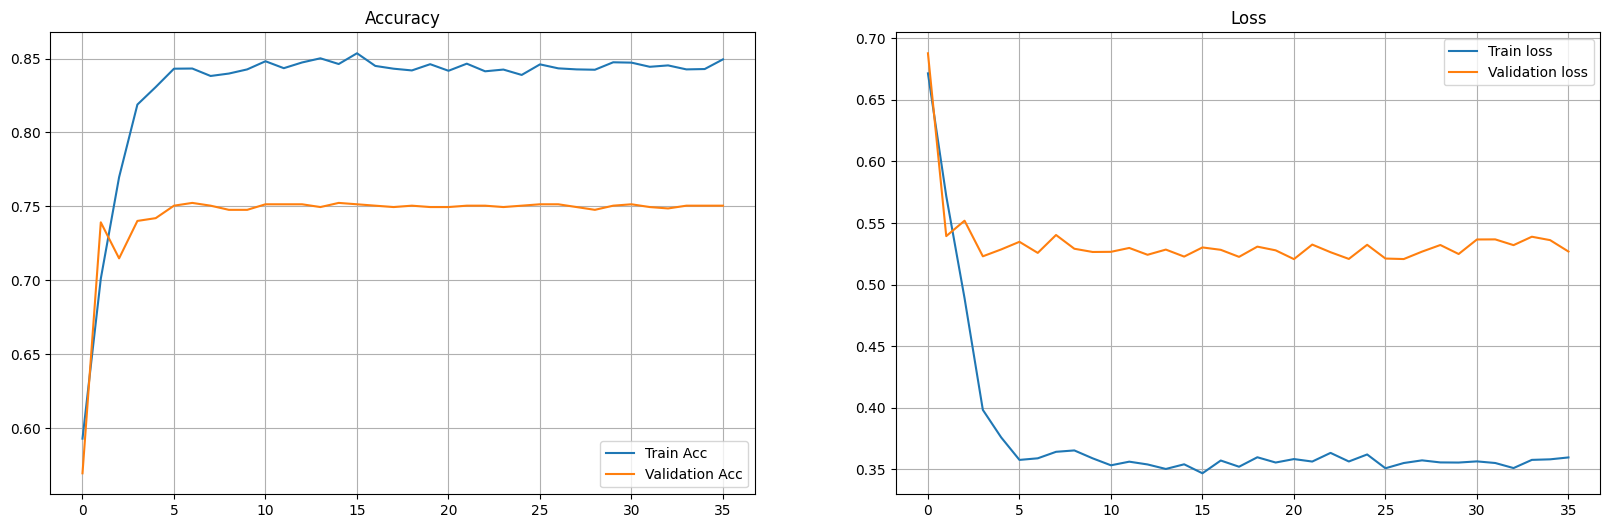

test_loss 0.461961, test_acc 0.784240


In [121]:
plot_loss_accuracy(train_loss_, train_acc_, val_loss_, val_acc_)

test_loss, test_acc = test_loop(test_loader, model, loss_fn, optimizer)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")

## RNN with Max and Average Pooling

Now we will test the model with Max pooling and Average pooling and concatenate the results with the output of the RNN layer. In
Part 2, we explore the use of either, but now we try to concatenate the results of both pooling methods. We aim to see if the model can make use of both pooling methods to improve the performance of the model.

In [88]:
class RNN_MaxAvePooling(nn.Module):

    def __init__(
        self,
        hidden_dim: int,
        embedding_dim: int,
        word_embeddings: torch.Tensor,
        pad_idx,
        num_layers=1,
        output_size=1,
        dropout_rate=0
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=False, padding_idx=pad_idx)
        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, num_layers, batch_first=True
        )  # this is the num rows of the input matrix
        
        # note that because we are using a concatenate of max and average pooling, the output size of the linear layer should be 2*hidden_dim
        self.fc = nn.Linear(2*hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, text_lengths):
        embedded = self.embedding(x)
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        if self.dropout_rate > 0:
            embedded = self.dropout(self.embedding(x)).float()
        else:
            embedded = self.embedding(x).float()

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted = False)
        packed_output, _ = self.rnn(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        if self.dropout_rate > 0:
            output = self.dropout(output)
        
        # max pooling
        output1, _ = torch.max(output, 1)
        # average pooling
        output2 = torch.mean(output, 1)
        # concatenate max and average pooling
        output = torch.cat((output1, output2), 1)

        out = self.fc(output)  # Use the last output of the RNN for classification

        sig_out = self.sigmoid(out)
        sig_out = sig_out.squeeze(1)
        # print("Sig_out shape: ", sig_out.shape)
        return sig_out

In [89]:
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()
word_embeddings.add_unk_token()

print("The index of <PAD> is: ", word_embeddings.pad_idx)


rnn_with_maxave_pool = RNN_MaxAvePooling(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    dropout_rate=0.2,
    pad_idx=word_embeddings.pad_idx,
    num_layers=1,
)

The index of <PAD> is:  16163


In [90]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
es_patience = 15

model = rnn_with_maxave_pool
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.05)

model = model.to(device)
loss_fn = loss_fn.to(device)

In [91]:
train_loss_, train_acc_, val_loss_, val_acc_ = train_model(train_loader, val_loader, model, loss_fn, optimizer, scheduler, epochs, es_patience)

  1%|          | 1/100 [00:02<03:56,  2.38s/it]

epoch 1, train_loss 0.632399 train_acc 0.619461, val_loss 0.493211, val_acc 0.766417


 11%|█         | 11/100 [00:25<03:34,  2.41s/it]

epoch 11, train_loss 0.067828 train_acc 0.978077, val_loss 0.660866, val_acc 0.758912


 15%|█▌        | 15/100 [00:38<03:37,  2.55s/it]

early stopping after 16 epochs
best val loss: 0.49321104857054626
best accuracy on val set: 0.7664165103189493


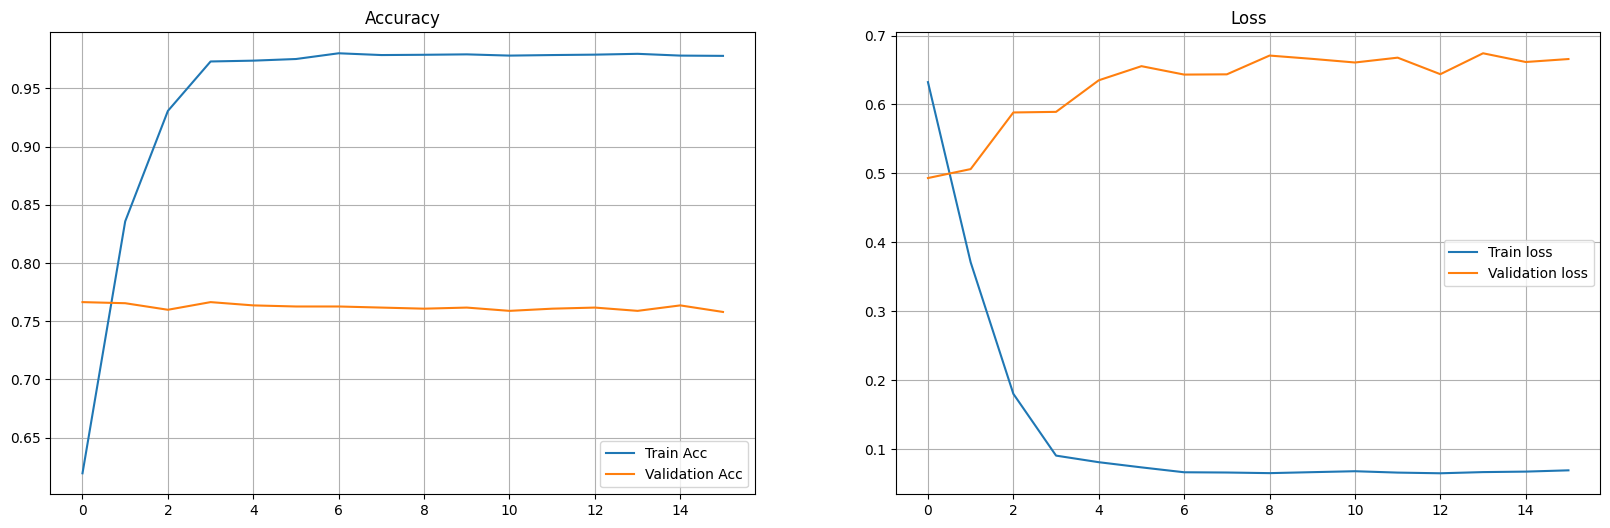

test_loss 0.604379, test_acc 0.782364


In [92]:
plot_loss_accuracy(train_loss_, train_acc_, val_loss_, val_acc_)

test_loss, test_acc = test_loop(test_loader, model, loss_fn, optimizer)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")

## Self Attention

We now explore what was taught in lectures, which is self attention where the model
tries to learn how to apply attention to the input sequence. We will add a self attention layer
and a Residual connection to the model. We aim to see if the model can learn to focus on the most
important words in the input sequence and hence improve the performance of the model.

In [ ]:
import torch

class SelfAttention(nn.Module):
    """
    Multi-head self attention layer
    """
    def __init__(self, embed_dim, heads=5, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.heads = heads
        self.head_dim = embed_dim // heads

        assert (
            self.head_dim * heads == embed_dim
        ), "Embedding dimension must be divisible by number of heads"

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape  # Batch size, sequence length, embedding dimension
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Calculate attention scores
        attn = (q @ k.transpose(-2, -1)) * self.head_dim**-0.5
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        # Apply attention to values
        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        return out
class SelfAttentionResNet(nn.Module):

    def __init__(
        self,
        hidden_dim: int,
        embedding_dim: int,
        word_embeddings: torch.Tensor,
        pad_idx,
        heads=5,
        num_layers=1,
        output_size=1,
        dropout_rate=0
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.heads = heads
        
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=False, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout_rate)

        self.self_attention_layers = nn.ModuleList([
            SelfAttention(embedding_dim, heads, dropout_rate) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embedding_dim, output_size)

        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x, text_lengths):
        embedded = self.embedding(x)
        
        out = embedded
        for layer in self.self_attention_layers:
            out = layer(out) + out  # Residual connection

        out = torch.mean(out, dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        
        sig_out = self.sigmoid(out)
        sig_out = sig_out.squeeze(1)
        return sig_out

In [109]:
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()
word_embeddings.add_unk_token()

print("The index of <PAD> is: ", word_embeddings.pad_idx)


self_atten_resnet = SelfAttentionResNet(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    dropout_rate=0.5,
    pad_idx=word_embeddings.pad_idx,
    num_layers=1,
)

The index of <PAD> is:  16163


In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
es_patience = 15

model = self_atten_resnet
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.05)

model = model.to(device)
loss_fn = loss_fn.to(device)

In [111]:
train_loss_, train_acc_, val_loss_, val_acc_ = train_model(train_loader, val_loader, model, loss_fn, optimizer, scheduler, epochs, es_patience)

  1%|          | 1/100 [00:02<03:46,  2.29s/it]

epoch 1, train_loss 0.576532 train_acc 0.713482, val_loss 0.516629, val_acc 0.757974


 11%|█         | 11/100 [00:24<03:13,  2.17s/it]

epoch 11, train_loss 0.032509 train_acc 0.988159, val_loss 1.565911, val_acc 0.749531


 15%|█▌        | 15/100 [00:35<03:20,  2.36s/it]

early stopping after 16 epochs
best val loss: 0.516628613526171
best accuracy on val set: 0.7579737335834896


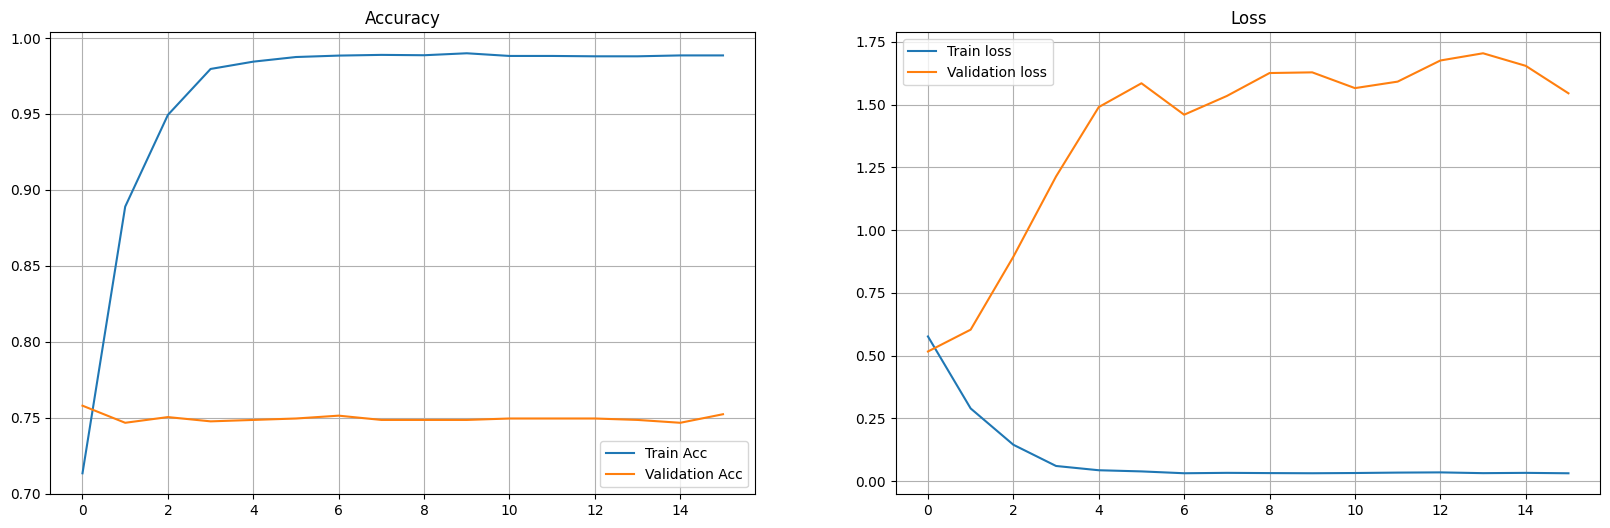

test_loss 1.727579, test_acc 0.765478


In [112]:
plot_loss_accuracy(train_loss_, train_acc_, val_loss_, val_acc_)

test_loss, test_acc = test_loop(test_loader, model, loss_fn, optimizer)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")

## Self Attention with layers

In [ ]:
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()
word_embeddings.add_unk_token()

print("The index of <PAD> is: ", word_embeddings.pad_idx)


self_atten_resnet = SelfAttentionResNet(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    dropout_rate=0.5,
    pad_idx=word_embeddings.pad_idx,
    num_layers=2,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
es_patience = 15

model = self_atten_resnet
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.05)

model = model.to(device)
loss_fn = loss_fn.to(device)

train_loss_, train_acc_, val_loss_, val_acc_ = train_model(train_loader, val_loader, model, loss_fn, optimizer, scheduler, epochs, es_patience)

The index of <PAD> is:  16163


  1%|          | 1/100 [00:03<06:11,  3.75s/it]

epoch 1, train_loss 0.656163 train_acc 0.664009, val_loss 0.854212, val_acc 0.545966


 11%|█         | 11/100 [00:40<05:29,  3.70s/it]

epoch 11, train_loss 0.317154 train_acc 0.870809, val_loss 0.624156, val_acc 0.727017


 18%|█▊        | 18/100 [01:10<05:21,  3.92s/it]

early stopping after 19 epochs
best val loss: 0.6002048741687428
best accuracy on val set: 0.7270168855534709


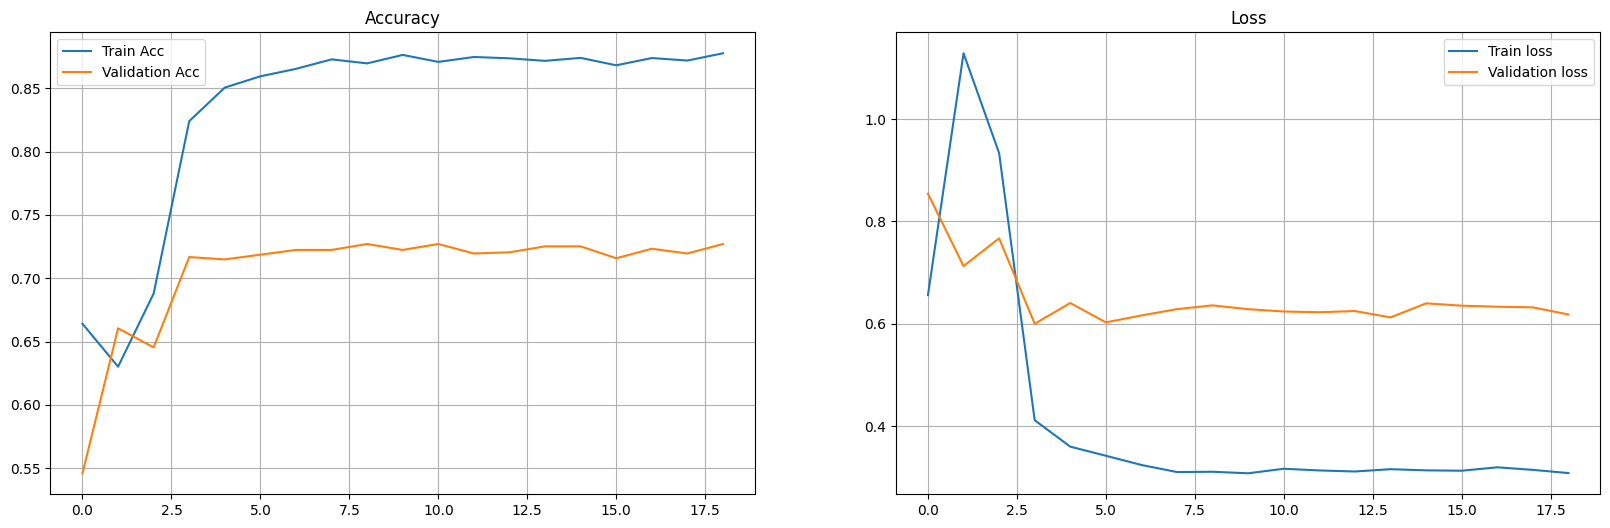

test_loss 0.554894, test_acc 0.746717


In [86]:
plot_loss_accuracy(train_loss_, train_acc_, val_loss_, val_acc_)

test_loss, test_acc = test_loop(test_loader, model, loss_fn, optimizer)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")

## Self Attention with Positional Encoding

In [115]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class SelfAttentionResNetPositionalEncoding(nn.Module):

    def __init__(
        self,
        hidden_dim: int,
        embedding_dim: int,
        word_embeddings: torch.Tensor,
        pad_idx,
        heads=5,
        num_layers=1,
        output_size=1,
        dropout_rate=0
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.heads = heads
        
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=False, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout_rate)
        self.pos_encoder = PositionalEncoding(embedding_dim, dropout_rate)
        # self.self_attention = SelfAttention(embedding_dim, heads)
        
        self.self_attention_layers = nn.ModuleList([
            SelfAttention(embedding_dim, heads, dropout_rate) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embedding_dim, output_size)

        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x, text_lengths):
        embedded = self.embedding(x)
        embedded = self.pos_encoder(embedded)
        
        out = embedded
        for layer in self.self_attention_layers:
            out = layer(out) + out  # Residual connection
            
        out = torch.mean(out, dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        
        sig_out = self.sigmoid(out)
        sig_out = sig_out.squeeze(1)
        # print("Sig_out shape: ", sig_out.shape)
        return sig_out

In [116]:
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()
word_embeddings.add_unk_token()

print("The index of <PAD> is: ", word_embeddings.pad_idx)


self_atten_resnet = SelfAttentionResNetPositionalEncoding(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    dropout_rate=0.5,
    pad_idx=word_embeddings.pad_idx,
    num_layers=1,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
es_patience = 15

model = self_atten_resnet
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.05)

model = model.to(device)
loss_fn = loss_fn.to(device)

train_loss_, train_acc_, val_loss_, val_acc_ = train_model(train_loader, val_loader, model, loss_fn, optimizer, scheduler, epochs, es_patience)

The index of <PAD> is:  16163


  1%|          | 1/100 [00:02<04:30,  2.74s/it]

epoch 1, train_loss 0.722830 train_acc 0.510082, val_loss 0.643709, val_acc 0.629456


 11%|█         | 11/100 [00:29<03:54,  2.63s/it]

epoch 11, train_loss 0.468679 train_acc 0.784291, val_loss 0.596931, val_acc 0.729831


 21%|██        | 21/100 [00:54<03:12,  2.44s/it]

epoch 21, train_loss 0.470679 train_acc 0.785229, val_loss 0.592550, val_acc 0.735460


 27%|██▋       | 27/100 [01:13<03:17,  2.71s/it]

early stopping after 28 epochs
best val loss: 0.5776040791110559
best accuracy on val set: 0.7457786116322702


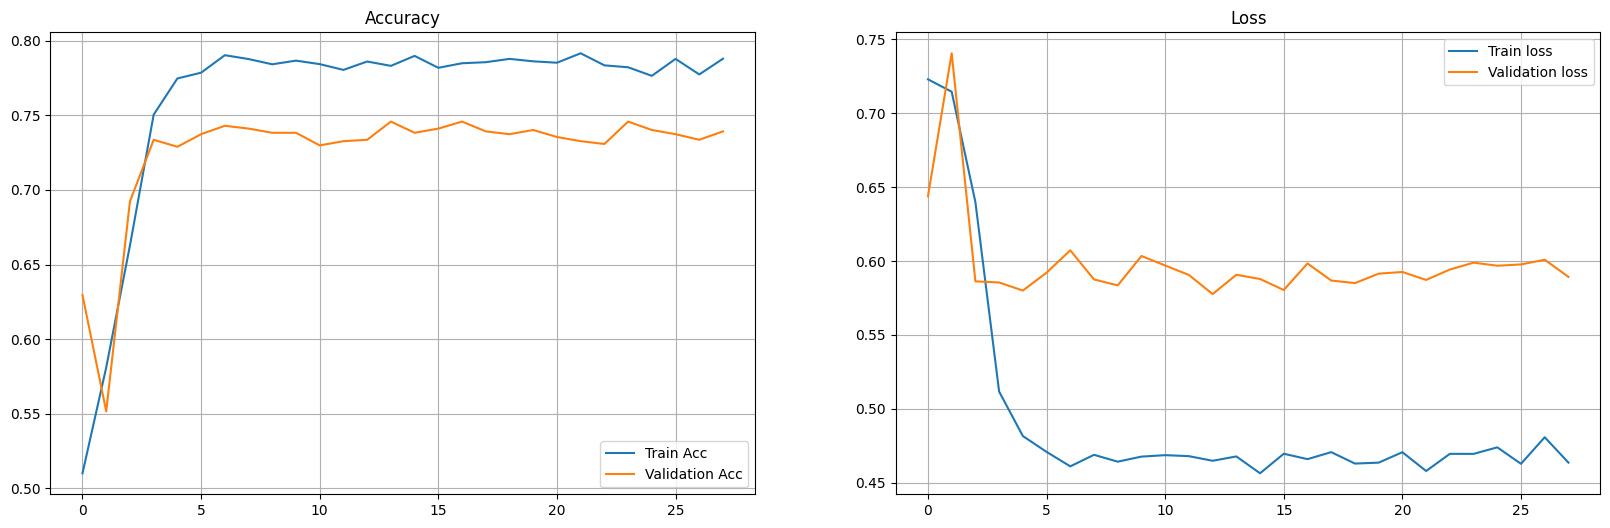

test_loss 0.549816, test_acc 0.742964


In [117]:
plot_loss_accuracy(train_loss_, train_acc_, val_loss_, val_acc_)

test_loss, test_acc = test_loop(test_loader, model, loss_fn, optimizer)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")